In [87]:
 # run with python3 lattice.gas.py --visualize to switch on real time visualization of configurations

In [88]:

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse  # Added for command-line argument parsing
from numba import njit  # For just-in-time compilation to speed up performance-critical functions

In [89]:
# Define nearest-neighbor directions (up, down, left, right)
NEIGHBORS = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

In [90]:
# Compute the energy change resulting from swapping two particles
@njit
def delta_energy(lattice, L, i1, j1, i2, j2):
    n1 = lattice[i1, j1]
    n2 = lattice[i2, j2]
    s1 = 0
    s2 = 0
    # Compute the sum of neighbors for each site
    for d in NEIGHBORS:
        ii1 = (i1 + d[0]) % L
        jj1 = (j1 + d[1]) % L
        s1 += lattice[ii1, jj1]
        ii2 = (i2 + d[0]) % L
        jj2 = (j2 + d[1]) % L
        s2 += lattice[ii2, jj2]
    # Return the energy difference caused by swapping
    return (n1 - n2) * (s1 - s2)

In [91]:
# Perform a Metropolis sweep using pre-generated indices of swap sites
@njit
def sweep_with_indices(lattice, L, T, indices):
    accepted = 0
    attempted = 0
    for i in range(indices.shape[0]):
        i1, j1, i2, j2 = indices[i]
        dE = delta_energy(lattice, L, i1, j1, i2, j2)
        attempted += 1
        # Accept the swap if it lowers energy or with Boltzmann probability
        if dE <= 0 or np.random.rand() < np.exp(-dE / T):
            tmp = lattice[i1, j1]
            lattice[i1, j1] = lattice[i2, j2]
            lattice[i2, j2] = tmp
            accepted += 1
    return accepted, attempted

In [92]:
# Generate valid particle swap pairs avoiding self-swaps and nearest neighbors
def generate_valid_indices(L, n):
    indices = []
    while len(indices) < n:
        i1, j1 = np.random.randint(0, L, 2)
        i2, j2 = np.random.randint(0, L, 2)
        if i1 == i2 and j1 == j2:
            continue
        di = min(abs(i1 - i2), L - abs(i1 - i2))
        dj = min(abs(j1 - j2), L - abs(j1 - j2))
        # Avoid adjacent sites (ensures detailed balance)
        if di + dj == 1:
            continue
        indices.append((i1, j1, i2, j2))
    return np.array(indices, dtype=np.int32)

In [93]:
# Compute the structure factor (square of Fourier transform of density fluctuations)
def compute_structure_factor(config):
    rho = config.astype(np.float32) - np.mean(config)
    F = np.fft.fftshift(np.fft.fft2(rho))
    return np.abs(F) ** 2

In [94]:
# Compute the pair correlation function g(r)
def compute_pair_correlation(config, n_bins=50):
    L = config.shape[0]
    particles = np.argwhere(config)
    # Compute all pairwise distances
    diffs = particles[:, None, :] - particles[None, :, :]
    diffs = (diffs + L/2) % L - L/2  # Apply periodic boundary conditions
    dists = np.sqrt((diffs**2).sum(axis=2)).ravel()
    edges = np.linspace(0, L/np.sqrt(2), n_bins + 1)
    hist, _ = np.histogram(dists, bins=edges)
    r = 0.5 * (edges[:-1] + edges[1:])
    rho = config.mean()
    dr = edges[1] - edges[0]
    norm = 2 * np.pi * r * dr * rho * len(particles)
    g = hist / norm
    return r, g

In [95]:
# Compute radial average of a 2D array (e.g., structure factor)
def radial_average(S, n_bins=50):
    L = S.shape[0]
    y, x = np.indices((L, L))
    r = np.sqrt((x - L//2)**2 + (y - L//2)**2)
    r_flat = r.ravel()
    S_flat = S.ravel()
    bins = np.linspace(0, r.max(), n_bins + 1)
    inds = np.digitize(r_flat, bins)
    radial_S = np.zeros(n_bins)
    for i in range(1, n_bins + 1):
        mask = inds == i
        if np.any(mask):
            radial_S[i-1] = S_flat[mask].mean()
    r_centers = 0.5 * (bins[:-1] + bins[1:])
    return r_centers, radial_S

In [96]:

# Compute total energy of the lattice
@njit
def compute_total_energy(lattice, L):
    energy = 0.0
    for i in range(L):
        for j in range(L):
            n = lattice[i, j]
            for d in NEIGHBORS:
                ni = (i + d[0]) % L
                nj = (j + d[1]) % L
                energy -= 0.5 * n * lattice[ni, nj]  # Avoid double counting
    return energy

In [ ]:
# ------------------ Main Simulation ------------------
import os
live_viz = False
print(f"Live visualization: {'ON' if live_viz else 'OFF'}")
plt.ion()  # Interactive mode on for live visualization

density = 0.5  # Initial particle density. Do not adjust this.

# Adjustable simulation parameters
L = 50  # Lattice size
T = 0.4  # Temperature
n_sweeps_eq = 200  # Number of sweeps to equilibrate
n_sweeps_per_meas = 10  # Sweeps between measurements
n_meas = 200  # Number of measurements

# Initialize lattice with random particle configuration
lattice = (np.random.rand(L, L) < density).astype(np.uint8)
total_accept = 0
total_attempt = 0
accum_g = None
accum_S = None

# Equilibration phase: relax the system to equilibrium at the prescribed T

for _ in tqdm(range(n_sweeps_eq), desc='Equilibrating'):  # Displays a progress bar for equilibration
    indices = generate_valid_indices(L, L * L)
    a, b = sweep_with_indices(lattice, L, T, indices)
    total_accept += a
    total_attempt += b

# Measurement phase where we at intervals sample observables: the radial distribution function g(r) and the structure factor

for _ in tqdm(range(n_meas), desc='Sampling'):  # Displays a progress bar for sampling
    if live_viz:
        plt.clf()
        plt.imshow(lattice, cmap="gray", vmin=0, vmax=1)
        plt.title(f"Lattice (meas step {_})")
        plt.pause(0.001)
    for _ in range(n_sweeps_per_meas):
        indices = generate_valid_indices(L, L * L)
        a, b = sweep_with_indices(lattice, L, T, indices)
        total_accept += a
        total_attempt += b
    r_vals, g = compute_pair_correlation(lattice)
    S = compute_structure_factor(lattice)
    # Accumulate the sum of instantaneous forms of g(r) and S(k) 
    if accum_g is None:
        accum_g = np.zeros_like(g)
        accum_S = np.zeros_like(S)
    accum_g += g
    accum_S += S
    
    # Accumulate the sum of instantaneous energy and its square 
    energy = compute_total_energy(lattice, L)
    if 'accum_energy' not in locals():
        accum_energy = 0.0
        accum_energy_sq = 0.0
    accum_energy += energy
    accum_energy_sq += energy ** 2

Live visualization: OFF


Sampling: 100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


In [98]:
# Average observables over measurements
g_avg = accum_g / n_meas
S_avg = accum_S / n_meas

E_avg = accum_energy / n_meas
E2_avg = accum_energy_sq / n_meas

heat_capacity = (E2_avg - E_avg**2) / (T**2)
print(f"Heat capacity per site: {heat_capacity / (L * L):.4f}")

Heat capacity per site: -28007.0564


In [99]:
# compute the radially averaged structure factor
r_S, S_rad = radial_average(S_avg) 

# Compute the heat capacity and specific heat
heat_capacity = (E2_avg - E_avg**2) / (T**2)
print(f"Heat capacity per site: {heat_capacity / (L * L):.4f}")

Heat capacity per site: -28007.0564


In [100]:
# Set up path and folders to save results
root_dir="/Users/phxnw/Dropbox/course-disordered-matter/Coursework/"
os.makedirs(os.path.join(root_dir, "figures"), exist_ok=True)
os.makedirs(os.path.join(root_dir, "data"), exist_ok=True)
prefix = f"L{L}_rho{density:.2f}_T{T:.2f}"

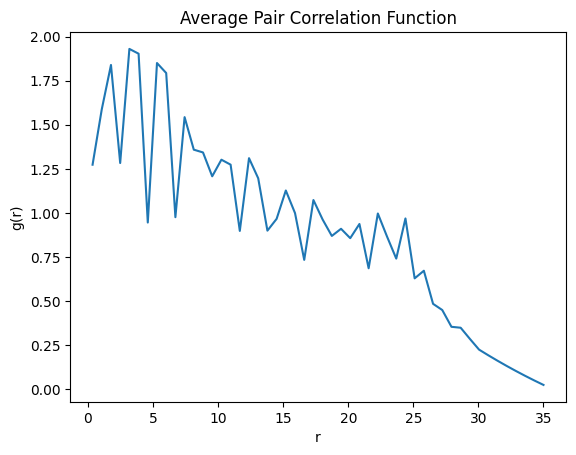

In [101]:
# Plot and save g(r)
plt.figure()
plt.plot(r_vals, g_avg)
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Average Pair Correlation Function")
plt.savefig(root_dir+f"figures/{prefix}_pair_correlation.pdf")

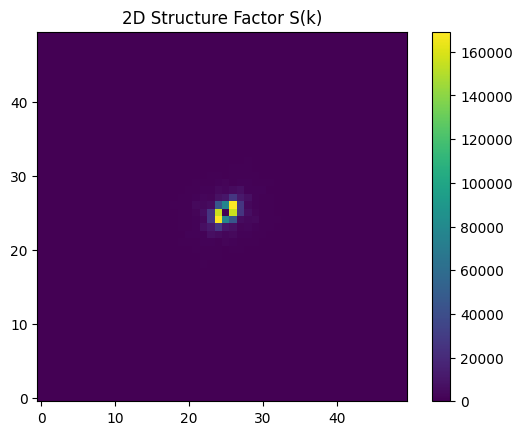

In [102]:
# Plot and save 2d S(k)
plt.figure()
plt.imshow(S_avg, origin="lower")
plt.title("2D Structure Factor S(k)")
plt.colorbar()
plt.savefig(root_dir + f"figures/{prefix}_structure_factor_2d.pdf")

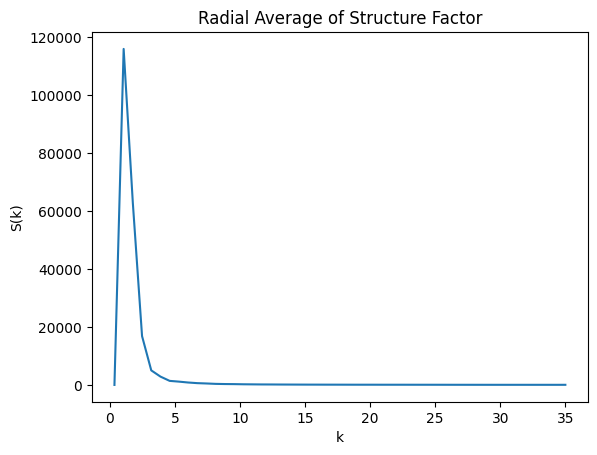

In [103]:
# Plot and save 1d S(|k|)
plt.figure()
plt.plot(r_S, S_rad)
plt.xlabel("k")
plt.ylabel("S(k)")
plt.title("Radial Average of Structure Factor")
plt.savefig(root_dir + f"figures/{prefix}_structure_factor_radial.pdf")
# Write out structure factor for analysis.
output_path = root_dir + f"data/{prefix}_structure_factor_radial.csv"
np.savetxt(output_path, np.column_stack((r_S, S_rad)), delimiter=",", header="k,S(k)", comments='')

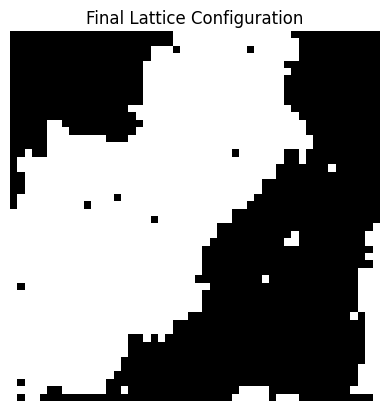

In [104]:
# Plot and save final particle configuration
plt.figure()
plt.imshow(lattice, cmap="gray")
plt.axis("off")
plt.title("Final Lattice Configuration")
plt.savefig(root_dir + f"figures/{prefix}_final_lattice.pdf")

In [105]:
plt.show()

In [106]:
# Save energy and heat capacity measurements for this temperature 
heat_output_path = root_dir + f"data/{prefix}_heat_capacity.txt"
with open(heat_output_path, "w") as f:
    f.write(f"# Heat capacity per site\n")
    f.write(f"C_per_site = {heat_capacity / (L * L):.6f}\n")
    f.write(f"# Average Energy = {E_avg:.6f}\n")
    f.write(f"# Average Energy^2 = {E2_avg:.6f}\n")

In [107]:
# Print final acceptance rate
print(f"Acceptance rate: {total_accept / total_attempt:.4f}")


Acceptance rate: 0.5095
